In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
# Download the stopwords and tokenizer from nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /Users/Steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Steve/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
df = pd.read_excel('Legal_Sentences_For_Training_With_BERT_With_Label.xlsx')
display(df.head())

test_sentences_df = pd.read_excel('Testing_Set_Legal_Sentences.xlsx')
display(test_sentences_df.head())

both_df = pd.concat([df, test_sentences_df])
display(both_df.head())

,ID,Phrase,Sentiment,Label
0,1,Getting nowhere with surplusage,-1,0
1,2,But the Court nowhere suggested that it would ...,-1,0
2,3,Petitioners objection to shaving his beard cla...,-1,0
3,4,That result clashes with everything else,-1,0
4,5,the tolerable duration of police inquiries in ...,0,1


,ID,sentence,label
0,1,has done nothing to satisfy the probable-cause...,0
1,2,"Addressing that question here , the CCA referr...",1
2,3,standards and procedures,1
3,4,has no comprehension of why he has been single...,0
4,5,"an expert , Dr. Woods , who offered the opinio...",2


,ID,Phrase,Sentiment,Label,sentence,label
0,1,Getting nowhere with surplusage,-1.0,0.0,NaN,NaN
1,2,But the Court nowhere suggested that it would ...,-1.0,0.0,NaN,NaN
2,3,Petitioners objection to shaving his beard cla...,-1.0,0.0,NaN,NaN
3,4,That result clashes with everything else,-1.0,0.0,NaN,NaN
4,5,the tolerable duration of police inquiries in ...,0.0,1.0,NaN,NaN


# EDA

In [9]:
# Checking for missing values in dfs 
print("Missing values of main df", df.isnull().sum())
print("Missing values of test df", test_sentences_df.isnull().sum())
print("Missing values when combining df", both_df.isnull().sum())

Missing values of main df ID           0
Phrase       0
Sentiment    0
Label        0
dtype: int64
Missing values of test df ID          0
sentence    0
label       0
dtype: int64
Missing values when combining df ID             0
Phrase       500
Sentiment    500
Label        500
sentence     576
label        576
dtype: int64


All labels for training data [0, 1, 2]
Occurances per labels above [282, 122, 172]


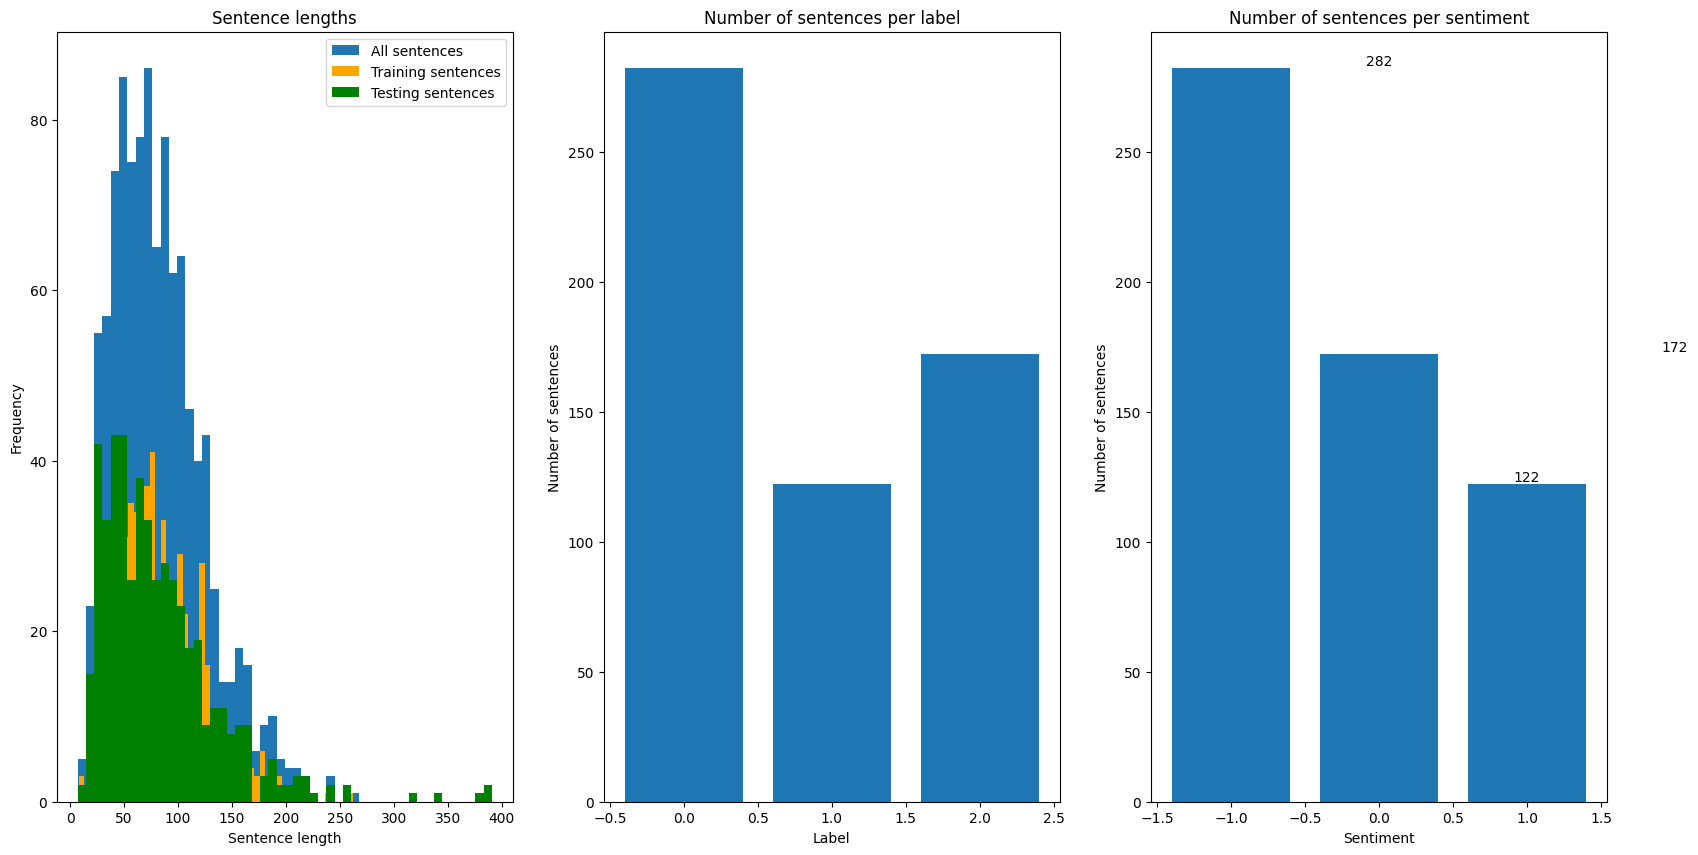

In [82]:
# Creating plot of sentence lengths, to see if there are any outliers
sentences = list(df['Phrase'])
sentences.extend(list(test_sentences_df['sentence']))
sentence_lengths = [len(sentence) for sentence in sentences]

# Distingush between training and testing sentences in plot
train_lengths = sentence_lengths[:len(df)]
test_lengths = sentence_lengths[len(df):]

# Plotting the sentence lengths in a histogram
# plt.figure(figsize=(30,8))
# using tuple unpacking for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# ax1.subplot(1,2,1)
ax1.hist(sentence_lengths, bins=50)
# add the test and train lengths to the plot and distringuish between them wih different colors
ax1.hist(train_lengths, bins=50, color='orange')
ax1.hist(test_lengths, bins=50, color='green')
ax1.set_xlabel('Sentence length')
ax1.set_ylabel('Frequency')
ax1.set_title('Sentence lengths')
# creating a legend for the plot
ax1.legend(['All sentences', 'Training sentences', 'Testing sentences'])

# Create a list of the unique labels
labels = list(df['Label'].unique())
print("All labels for training data", labels)

# Create a list of the number of sentences per label
num_sentences = [len(df[df['Label']==label]) for label in labels]
print("Occurances per labels above", num_sentences)

# Plot the number of sentences per label
ax2.bar(labels, num_sentences)
# add a value above each bar
for i in range(len(labels)):
    plt.text(labels[i], num_sentences[i], num_sentences[i], ha='center', va='bottom')
ax2.set_xlabel('Label')
ax2.set_ylabel('Number of sentences')
ax2.set_title('Number of sentences per label')

# Plotting umber of sentences per Sentiment column name
ax3.bar(df['Sentiment'].unique(), df['Sentiment'].value_counts())
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Number of sentences')
ax3.set_title('Number of sentences per sentiment')

plt.show()


# Preprocess the data

In [56]:
def preprocess_text(text):
    # Convert text to lowercase
    words = word_tokenize(text)

    # Convert words to lowercase
    words = [word.lower() for word in words]

    # Remove punctuation from words
    words = [word for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove duplicate words
    unique_words = list(dict.fromkeys(words))

    # Join the words back into a string
    text = ' '.join(unique_words)

    return text

def get_token_count(text):
    words = word_tokenize(text)
    return len(words)

def get_unique_words(text):
    words = word_tokenize(text)
    unique_words = list(dict.fromkeys(words))
    return unique_words

def get_unique_token_count(text):
    words = word_tokenize(text)
    unique_words = list(dict.fromkeys(words))
    return len(unique_words)


In [155]:

df['processed_phrase'] = df['Phrase'].apply(preprocess_text)
df['processed_phrase_token_count'] = df['processed_phrase'].apply(get_token_count) 
display(df.head())

,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count,unique_words,unique_w_count,sentiment_label
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3,"[getting, nowhere, surplusage]",3,negative
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8,"[court, nowhere, suggested, would, narrow, biv...",8,negative
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10,"[petitioners, objection, shaving, beard, clash...",10,negative
3,4,That result clashes with everything else,-1,0,result clashes everything else,4,"[result, clashes, everything, else]",4,negative
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7,"[tolerable, duration, police, inquiries, conte...",7,neutral


# Training the model

In [129]:
X = df['processed_phrase'].values
y = df['Label'].values

# Convert X to a NumPy array of shape (n_samples, 1) to match y's shape of (n_samples, n_labels)
# y.shape (2224, 5)
X = np.array(X).reshape(-1, 1)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Label distribution in test set:", np.sum(y_test, axis=0))
print("Label distribution in entire dataset:", np.sum(y, axis=0))

# Reshape to reshape nparrays from 2d to 1d for vectorization
X_train = X_train.reshape(-1)
X_test = X_test.reshape(-1)


Label distribution in test set: 109
Label distribution in entire dataset: 466


# Semantic Analysis

### TF-IDF or word embeddings (Words2Vec). Which one is better?

In [154]:
df['unique_words'] = df['processed_phrase'].apply(get_unique_words) 
df['unique_w_count'] = df['processed_phrase'].apply(get_unique_token_count) 
display(df.head())

,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count,unique_words,unique_w_count,sentiment_label
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3,"[getting, nowhere, surplusage]",3,negative
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8,"[court, nowhere, suggested, would, narrow, biv...",8,negative
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10,"[petitioners, objection, shaving, beard, clash...",10,negative
3,4,That result clashes with everything else,-1,0,result clashes everything else,4,"[result, clashes, everything, else]",4,negative
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7,"[tolerable, duration, police, inquiries, conte...",7,neutral


In [144]:
# Vectorizing the data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
display(X_test_tfidf)

<144x1827 sparse matrix of type '<class 'numpy.float64'>'
	with 661 stored elements in Compressed Sparse Row format>

In [145]:
# Create skip-gram model on the processed phrases
tokenized_texts = [word_tokenize(text) for text in df['processed_phrase']]
skipgram_model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, sg=1)
print("Skip-gram model vocabulary size:", len(skipgram_model.wv))

# Test semantic similarity using the Skip-gram model
word1 = "good"
word2 = ["supreme", "tragic", "probable","laws","police", "liberty", "well"]

for word in word2: 
    print("Semantic similarity between '{}' and '{}':".format(word1, word), skipgram_model.wv.similarity(word1, word))


Skip-gram model vocabulary size: 2217
Semantic similarity between 'good' and 'supreme': -0.02299997
Semantic similarity between 'good' and 'tragic': -0.12294621
Semantic similarity between 'good' and 'probable': -0.020557588
Semantic similarity between 'good' and 'laws': 0.1907059
Semantic similarity between 'good' and 'police': -0.06996367
Semantic similarity between 'good' and 'liberty': -0.19201866
Semantic similarity between 'good' and 'well': 0.07753625


# Sentiment Analysis
### Using Vader

In [146]:
def get_subjecive_sentences(sentences, y_pred):
  subjective_sentences = []
  for i, sentence in enumerate(sentences):
    if y_pred[i] == 1:
      subjective_sentences.append(sentence)
  return subjective_sentences

def convert_sentiment_to_string(sentiment):
  if sentiment == -1:
    return 'negative'
  elif sentiment == 0:
    return 'neutral'
  else:
    return 'positive'

### Converting to setiment to string for easier reading

In [147]:
df['sentiment_label'] = df['Sentiment'].apply(convert_sentiment_to_string)
display(df.head())

,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count,unique_words,unique_w_count,sentiment_label
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3,"[getting, nowhere, surplusage]",3,negative
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8,"[court, nowhere, suggested, would, narrow, biv...",8,negative
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10,"[petitioners, objection, shaving, beard, clash...",10,negative
3,4,That result clashes with everything else,-1,0,result clashes everything else,4,"[result, clashes, everything, else]",4,negative
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7,"[tolerable, duration, police, inquiries, conte...",7,neutral


## Using Naive Bayes Classifier

In [148]:
# Train the Naive Bayes Classifier
display(X_train_tfidf.shape)
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Test the classifier
y_pred = classifier.predict(X_test_tfidf)


(432, 1827)

Sentiment Analysis Classifier metrics:
Accuracy: 0.48
Precision: 0.32
Recall: 0.48
F1 Score: 0.37
AUC-ROC Score: 0.55


#### Evaluation Metrics

In [ ]:
def eval_metrics(X_test_tfidf, y_test, y_pred_tfidf, clf):
  # Evaluate using classification metrics
  accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
  precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
  recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
  f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

  # Using predict_proba which peformed similar results to decision_function()
  roc_auc_tfidf = roc_auc_score(y_test, clf.predict_proba(X_test_tfidf), multi_class='ovr')

  # Display the classification metrics
  print(f"Accuracy: {accuracy_tfidf:.2}")
  print(f"Precision: {precision_tfidf:.2}")
  print(f"Recall: {recall_tfidf:.2}")
  print(f"F1 Score: {f1_score_tfidf:.2}")
  print(f"AUC-ROC Score: {roc_auc_tfidf:.2}")

In [153]:
# Evaluate the Naive Bayes classifier
print(f"Sentiment Analysis Classifier metrics (using Naive Bayes Classifier):")
eval_metrics(X_test_tfidf, y_test, y_pred, classifier)

Sentiment Analysis Classifier metrics (using Naive Bayes Classifier):
Accuracy: 0.48
Precision: 0.32
Recall: 0.48
F1 Score: 0.37
AUC-ROC Score: 0.55


Evaluation and Interpretation:  

Evaluate the performance of the sentiment analysis model using appropriate metrics (e.g., accuracy, precision, recall).  
Interpret the results and discuss the challenges and limitations of sentiment analysis in this context.  

Discussion and Applications:  

Reflect on the importance of Semantic and Sentiment Analysis in understanding customer feedback and its potential applications in business and   marketing strategies.

Propose ways in which the insights gained from this analysis can be utilized to improve product quality and customer satisfaction.  